In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import regex as re

In [2]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device

device(type='mps')

In [3]:
do_download:bool=False
if do_download:
    !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [4]:
torch.manual_seed(1337)
B, T, C = 4, 8, 2
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

## Different methods to compute rolling mean on T axis.
like weighted sum with same weight on previous items of sequence

In [5]:
# method 1
xbow = torch.zeros((B, T, C))
xbow.shape
for b in range(B):
    for t in range(T):
        xprev = x[b, : t + 1]
        # print(b, t, xprev.shape)
        xbow[b, t] = torch.mean(xprev, 0)
        # print("-----")
        # print(xbow)

xbow.shape

torch.Size([4, 8, 2])

In [6]:
# method 2
wei = torch.tril(torch.ones((T, T)))
# print(wei)
wei = wei / wei.sum(axis=1, keepdim=True)
print("weight", wei)
xbow2 = wei @ x  # B,T,C @ B,T,T ---> B,T,C
torch.allclose(xbow, xbow2)

weight tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


True

In [7]:
# method 3 using softmax
tril = torch.tril(torch.ones((T, T)))
wei = torch.zeros((T, T))
# print(wei)
wei = wei.masked_fill(tril == 0, value=float("-inf"))
# print(wei)
wei = F.softmax(wei, dim=1)
print("weight", wei)

xbow3 = wei @ x
torch.allclose(xbow, xbow3)

weight tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


True

# model

In [8]:
with open("./input.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [9]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {s: i for i, s in enumerate(chars)}
itos = {i: s for i, s in enumerate(chars)}


def encode(s: str) -> list[int]:
    return [stoi[c] for c in s]


def decode(l: list[int]) -> str:
    return "".join([itos[i] for i in l])

In [10]:
decode(encode("j'aime les chats"))
# stoi["a"], stoi["A"]

"j'aime les chats"

In [11]:
torch.manual_seed(42)
# Compute train and validation data
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(text))
train = data[:n]
val = data[n:]


def get_char_batch(split: str = "train", batch_size: int = 16, block_size: int = 8):
    data = train if split == "train" else val
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # ix are random starting points of each batch
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

In [12]:
x, y = get_char_batch(batch_size=16, block_size=8)
x, y
x.shape, y.shape

(torch.Size([16, 8]), torch.Size([16, 8]))

In [13]:
torch.manual_seed(42)
B, T, C = 16, 8, 32
x = torch.rand(B, T, C)

head_size = 32
key = nn.Linear(C, head_size)
k = key(x)
query = nn.Linear(C, head_size)
q = query(x)
value = nn.Linear(C, head_size)
v = value(x)

wei = q @ k.transpose(-2, -1) * head_size**-0.5
tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim=-1)

out = wei @ v
# out.shape

In [14]:
# test with a hard coded query and key
q = torch.tensor([[[0.0, 1.0], [2.0, 3.0], [4.0, 5.0]]])
k = torch.tensor([[[0.0, 1.0], [2.0, 3.0], [4.0, 5.0]]])
B, T, C = q.shape
q.shape
wei = q @ k.transpose(-2, -1)  # * head_size**-0.5
tril = torch.tril(torch.ones(T, T))
# wei = wei.masked_fill(tril == 0, float("-inf"))
# wei = F.softmax(wei, dim=-1)
wei

tensor([[[ 1.,  3.,  5.],
         [ 3., 13., 23.],
         [ 5., 23., 41.]]])

In [15]:
n = int(0.9 * len(text))
train_txt = text[:n]
test_txt = text[n:]
train_txt

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [16]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
# tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit()
# GPT doen't use a normalizer but we add it here for demo purposes
normalizer = normalizers.Sequence([normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()])

In [17]:
normalizer.normalize_str(train_txt[:30])

'first citizen:\nbefore we proce'

In [18]:
for t, (s, e) in tokenizer.pre_tokenizer.pre_tokenize_str(train_txt[:50]):
    print(t, s, e, train_txt[s:e])

First 0 5 First
ĠCitizen 5 13  Citizen
: 13 14 :
Ċ 14 15 

Before 15 21 Before
Ġwe 21 24  we
Ġproceed 24 32  proceed
Ġany 32 36  any
Ġfurther 36 44  further
, 44 45 ,
Ġhear 45 50  hear


In [19]:
trainer = trainers.BpeTrainer(vocab_size=1000, special_tokens=["<|endoftext|>"])
tokenizer.train_from_iterator([train_txt], trainer=trainer)
tokenizer.get_vocab_size()
tokenizer.post_processor = processors.ByteLevel(trim_offsets=True)
tokenizer.decoder = decoders.ByteLevel()
encodings = tokenizer.encode(train_txt[:50])
print("tokens: ", encodings.tokens)
print("ids: ", encodings.ids)
print("decoded:", tokenizer.decode(encodings.ids))
# train_bpe = tokenizer.encode(train_txt).ids
# test_bpe = tokenizer.encode(test_txt).ids
print(f"offsets:{[train_txt[s:e] for s,e in encodings.offsets]}")




tokens:  ['First', 'ĠCitizen', ':', 'Ċ', 'Be', 'fore', 'Ġwe', 'Ġpro', 'ce', 'ed', 'Ġany', 'Ġf', 'ur', 'ther', ',', 'Ġhear']
ids:  [450, 928, 9, 64, 579, 365, 141, 391, 116, 125, 616, 81, 171, 510, 5, 487]
decoded: First Citizen:
Before we proceed any further, hear
offsets:['First', 'Citizen', ':', '\n', 'Be', 'fore', 'we', 'pro', 'ce', 'ed', 'any', 'f', 'ur', 'ther', ',', 'hear']


In [20]:
# create train and validation data for bpe based tokens
data = torch.tensor(tokenizer.encode(text).ids, dtype=torch.long)
n = int(0.9 * len(data))
train_bpe = data[:n]
val_bpe = data[n:]

In [21]:
def get_bpe_batch(split: str = "train", batch_size: int = 16, block_size: int = 8):
    data = train_bpe if split == "train" else val_bpe
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # ix are random starting points of each batch

    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y


get_bpe_batch(batch_size=2, block_size=8)

(tensor([[ 64, 137, 293,  42,  80, 199,   5, 106],
         [363, 107, 153,  94, 151, 104,   5, 317]], device='mps:0'),
 tensor([[137, 293,  42,  80, 199,   5, 106, 629],
         [107, 153,  94, 151, 104,   5, 317, 153]], device='mps:0'))

In [22]:
for i in range(2):
    x, y = get_bpe_batch(batch_size=16, block_size=8)
    print(x.shape, y.shape)
    print(x.to(int).tolist())
    print(tokenizer.decode_batch(x.to(int).tolist()))
    print(tokenizer.decode_batch(y.to(int).tolist()))
    print("-----")

torch.Size([16, 8]) torch.Size([16, 8])
[[87, 691, 6, 56, 45, 126, 476, 5], [11, 64, 64, 450, 260, 713, 430, 55], [125, 7, 64, 64, 30, 381, 244, 30], [59, 79, 125, 5, 397, 66, 69, 133], [55, 574, 76, 81, 172, 115, 98, 696], [1, 173, 192, 101, 727, 106, 562, 5], [640, 321, 810, 139, 210, 220, 391, 41], [178, 18, 178, 281, 9, 64, 601, 308], [398, 59, 519, 90, 188, 177, 620, 168], [40, 120, 293, 49, 69, 40, 187, 82], [112, 55, 384, 101, 267, 78, 58, 46], [328, 99, 11, 64, 341, 269, 784, 82], [49, 809, 7, 64, 64, 448, 24, 958], [413, 7, 64, 64, 627, 9, 64, 289], [51, 105, 141, 125, 56, 239, 89, 38], [76, 640, 139, 210, 132, 618, 180, 210]]
[' cock-shut time,', '?\n\nFirst Murderer', 'ed.\n\nSOMERS', 'vised, had touch', 'rough the false pass', '! this do I beg of God,', ' soul brought forth her prod', 'ARGARET:\nWho can', ' savageness aside have', 'cle Gloucester', " ground I'll bui", ' say you?\nMy prisoner', 'lcome.\n\nCAMIL', 'ence.\n\nMENENIUS:\nFor', 'ning weeds are la', ' the soul for

In [23]:
use_bpe: bool = False
if use_bpe:
    vocab_size = tokenizer.get_vocab_size()
    get_batch = get_bpe_batch
else:
    vocab_size = 65
    get_batch = get_char_batch

In [27]:
class Head(nn.Module):
    def __init__(self, head_size: int, n_embd: int, block_size: int, dropout: float = 0.1) -> None:
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.smax = nn.Softmax(dim=-1)
        self.register_buffer("tril", tensor=torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        wei = self.smax(wei)  # F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, head_size: int, block_size: int, n_embd: int, dropout: float = 0.1) -> None:
        super().__init__()
        self.heads = nn.ModuleList(
            [Head(head_size, block_size=block_size, n_embd=n_embd, dropout=dropout) for _ in range(num_heads)]
        )
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out


class FeedForward(nn.Module):
    def __init__(self, n_embd: int, dropout: float = 0.1) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), nn.ReLU(), nn.Linear(4 * n_embd, n_embd), nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    def __init__(self, n_embd: int, num_heads: int, block_size: int, dropout: float = 0.1):
        super().__init__()
        head_size = n_embd // num_heads
        self.sa = MultiHeadAttention(
            num_heads=num_heads, head_size=head_size, block_size=block_size, n_embd=n_embd, dropout=dropout
        )
        self.ffwd = FeedForward(n_embd, dropout=dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class GPTLanguageModel(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        num_heads: int = 4,
        n_embd: int = 32,
        block_size: int = 8,
        num_layers: int = 2,
        dropout: float = 0.1,
    ) -> None:
        super().__init__()
        self.num_heads = num_heads
        self.block_size = block_size
        self.n_embd = n_embd
        self.num_layers = num_layers
        self.token_emb = torch.nn.Embedding(vocab_size, n_embd)
        self.pos_emb = torch.nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, num_heads, block_size, dropout=dropout) for _ in range(num_layers)])
        self.layer_norm = nn.LayerNorm(n_embd)
        self.lm_head = torch.nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos_emb = self.pos_emb(torch.arange(T, device=device))
        # print("pos_emb shape", pos_emb.shape)
        x = tok_emb + pos_emb  # B, T, C
        # print(f"x shape: {x.shape}")
        x = self.blocks(x)
        x = self.layer_norm(x)
        logits = self.lm_head(x)

        # print(f"logits shape: {logits.shape}")
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size :]
            logits, _ = self(idx_cond)
            # print("generate logit shape", logits.shape)

            logits = logits[:, -1, :]

            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


# hyperparams
batch_size = 64  # how many independent sequences will we process in parallel?
block_size = 256  # what is the maximum context length for predictions?


n_embd = 384
num_heads = 6
num_layers = 6
dropout = 0.2


model = GPTLanguageModel(
    vocab_size, num_heads=num_heads, num_layers=num_layers, n_embd=n_embd, block_size=block_size, dropout=dropout
)
model = model.to(device)
xb, yb = get_batch("train")
train_logit, train_loss = model(xb)
train_logit.shape

print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")
print("it should be about 10M")

10.788929 M parameters
it should be about 10M


In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, batch_size=batch_size, block_size=block_size)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


max_iters = 5001
eval_iters = 200
eval_interval = 500
learning_rate = 3e-4


# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

model_id = "cop_gpt"
model_version = "0.1"
log_dir = Path("../runs") / f"{model_id}-{model_version}" / f"{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"

writer = SummaryWriter(log_dir=log_dir)

do_train: bool = False
if do_train:
    for i in range(max_iters):
        # every once in a while evaluate the loss on train and val sets
        if i % eval_interval == 0:
            losses = estimate_loss()
            print(f"step {i}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            writer.add_scalar("loss/train", losses["train"], i)
            writer.add_scalar("loss/val", losses["val"], i)
            torch.save(model, f"gpt-{model_version}-{i}.pt")

        # sample a batch of data
        xb, yb = get_batch("train", batch_size=batch_size, block_size=block_size)

        # evaluate the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        for name, weight in model.named_parameters():
            writer.add_histogram(name, weight, i)

        optimizer.step()

    torch.save(model, f"gpt-{model_version}.pt")

In [30]:
iter = 3500
if not do_train:
    model = torch.load(f"gpt-{model_version}-{iter}.pt")

In [31]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
if use_bpe:
    print(tokenizer.decode(model.generate(context, max_new_tokens=200)[0].to(int).tolist()))
else:
    print(decode(model.generate(context, max_new_tokens=200)[0].tolist()))


Shall the narks fail infancy.
But, ay, as it is: my boom! lady a corse,
A hat overhooks, out as fallened. That any our patriments!
When do rest this rear when eyes over you never
To an a kind with suc


In [32]:
embeddings = model.state_dict()["token_emb.weight"]
metadata = [itos[i] for i in range(vocab_size)]


# Add embeddings to the writer
writer.add_embedding(embeddings, metadata=metadata)

# Close the writer
writer.close()

## Understand model behaviour

Capture the activation at various moment within the model

In [33]:
model.blocks

Sequential(
  (0): Block(
    (sa): MultiHeadAttention(
      (heads): ModuleList(
        (0-5): 6 x Head(
          (key): Linear(in_features=384, out_features=64, bias=False)
          (query): Linear(in_features=384, out_features=64, bias=False)
          (value): Linear(in_features=384, out_features=64, bias=False)
          (smax): Softmax(dim=-1)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
      (proj): Linear(in_features=384, out_features=384, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (ffwd): FeedForward(
      (net): Sequential(
        (0): Linear(in_features=384, out_features=1536, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1536, out_features=384, bias=True)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
    (ln1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    (ln2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (1): Block(
    (sa): MultiHeadAttention(
      (heads): M

In [34]:
activation = {}


def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()

    return hook


# register a hook to access activations of each head.
for b, block in enumerate(model.blocks):
    for i, h in enumerate(block.sa.heads):
        h.register_forward_hook(get_activation(f"block_{b}_head_{i}"))
        h.smax.register_forward_hook(get_activation(f"block_{b}_smax_{i}"))

model.lm_head.register_forward_hook(get_activation("lm_head"))

In [35]:
gen_toks = model.generate(context, max_new_tokens=8)
chars = [c for c in decode(gen_toks[0].tolist())]
chars

['\n', 'T', 'h', 'i', 's', ' ', 'u', 'n', 'a']

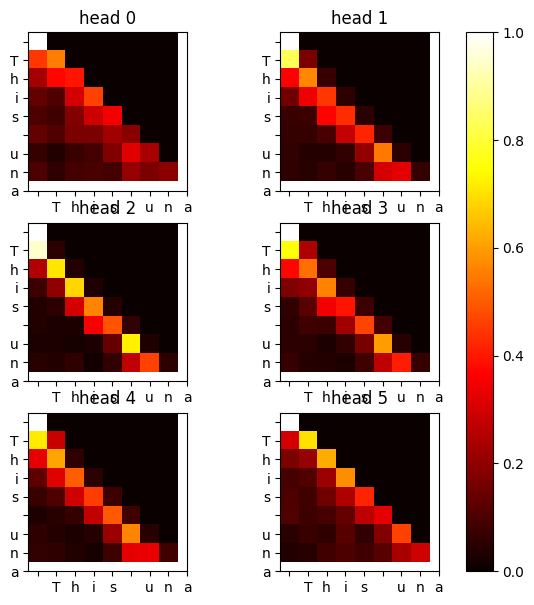

In [41]:
num_rows = num_heads // 2
num_cols = num_heads // num_rows
fig, axes = plt.subplots(num_rows, num_cols, figsize=(7, 7))
axes = axes.flatten()


for i, ax in enumerate(axes):
    im = ax.imshow(activation[f"block_0_smax_{i}"][0].cpu().numpy(), cmap="hot", interpolation="nearest")
    ax.set_title(f"head {i}")
    ax.set_xticks(np.arange(len(chars)), labels=chars)
    ax.set_yticks(np.arange(len(chars)), labels=chars)

cbar = fig.colorbar(im, ax=axes, orientation="vertical", fraction=0.1, pad=0.05)


# fig.colorbar(im, ax=ax)
# fig.tight_layout()

In [37]:
# plot histogramt (torch.histogram) for each output  distribution for each layer. Also plot gradient to check its normally distributed.
for l in model.blocks[0].sa.heads.named_parameters():
    print(l[0], l[1].shape)

0.key.weight torch.Size([64, 384])
0.query.weight torch.Size([64, 384])
0.value.weight torch.Size([64, 384])
1.key.weight torch.Size([64, 384])
1.query.weight torch.Size([64, 384])
1.value.weight torch.Size([64, 384])
2.key.weight torch.Size([64, 384])
2.query.weight torch.Size([64, 384])
2.value.weight torch.Size([64, 384])
3.key.weight torch.Size([64, 384])
3.query.weight torch.Size([64, 384])
3.value.weight torch.Size([64, 384])
4.key.weight torch.Size([64, 384])
4.query.weight torch.Size([64, 384])
4.value.weight torch.Size([64, 384])
5.key.weight torch.Size([64, 384])
5.query.weight torch.Size([64, 384])
5.value.weight torch.Size([64, 384])


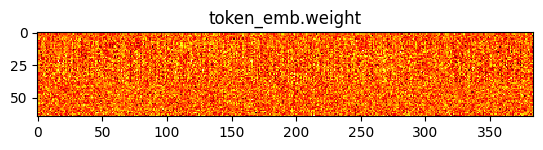

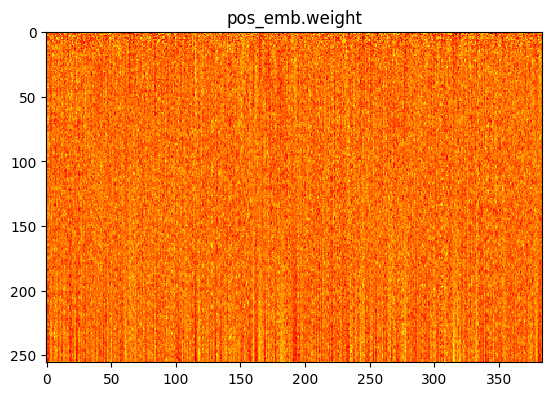

In [38]:
def display_params(model, layer_name):
    npp = model.state_dict()[layer_name].cpu().detach().numpy()

    plt.imshow(npp, cmap="hot", interpolation="nearest")
    plt.title(layer_name)
    plt.show()


display_params(model, "token_emb.weight")
display_params(model, "pos_emb.weight")

### view layer values

In [ ]:
Add mechanism to view attention on each token
https://www.comet.com/site/blog/explainable-ai-for-transformers/